In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.models import load_model
import pickle
import model as cls
%matplotlib inline
# target_class_index = 0  
index=173


In [2]:
#Test ori data
def load_data():
    test_x = np.load(r"C:\Users\nbalasubramanian\Documents\Research Work\New Data\Data-20240119T210557Z-001\Data\MIT Processed\Test Dataset\ecg_ori_all_reshaped_te_segments.npy")
    test_y = np.load(r"C:\Users\nbalasubramanian\Documents\Research Work\New Data\Data-20240119T210557Z-001\Data\MIT Processed\Test Dataset\ecg_ori_all_te_labels.npy")

    # print(test_x.shape)
    # print(test_y)

    return test_x[index]

In [3]:
# ckpt = ['\Aug_Jitter_T1\\Model_144','\Aug_Permute_T1\\Model_93', '\Aug_rotate_T1\\Model_124' ]
# ckpt=[r"\Flip_Model_44"]

ckpt=[r"\Scale_Model_121",
    #  r"\Jitter_Model_144",
    #  r"\Flip_Model_44",
      r"\No_Aug_CustomCNN_Lead0_44",
    #  r"\MagnitudeWarp_Model_102",
    #  r"\Permute_Model_93",
    #  r"\Rotate_Model_124",
    #  r"\TimeWarp_Model_115",
    #  r"\Window_Slice_Model_121",
    #  r"\Window_Warp_Model_114",
    ]

# ckpt=[r"\Aug_No_Aug_T2\No_Aug_Model_145"]
models = []
for m in ckpt:
    model = cls.classifier()
    # path = r"C:\Users\nbalasubramanian\Documents\Research Work\New Data\Code-20240119T232854Z-001\Code"+ m
    path = r"C:\Users\nbalasubramanian\Documents\Research Work\New Data\Models-20240119T210601Z-001\Models" + m
    model = cls.load_ckpt(model,path)
    models.append(model)

In [4]:
def grad_cam(signal, Model, target_class_index, layer_name='conv13' ):
    signal_tensor = tf.convert_to_tensor(signal, dtype=tf.float32)  
    grad_model = tf.keras.models.Model(
        inputs=[Model.inputs],
        outputs=[Model.get_layer(layer_name).output, Model.output]
    )
    
    with tf.GradientTape() as tape:
        tape.watch(signal_tensor)  
        conv_outputs, predictions = grad_model(signal_tensor)
        # print("Type of predictions:", type(predictions))
        # print("Content of predictions:", predictions)
        loss = predictions[1][:, target_class_index]
    
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=0)
    weighted_conv_outputs = conv_outputs[0] * pooled_grads
    
    heatmap = tf.reduce_sum(weighted_conv_outputs, axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

In [5]:
def plot_graph(Model, name, class_index):
    signal = load_data()
    signal = signal.reshape(1, -1, 1)
    heatmap = grad_cam(signal, Model, target_class_index=class_index, layer_name="conv13",)

    activation_threshold = 0.8

    thresholded_heatmap = np.where(heatmap > activation_threshold, heatmap, 0)
    normalized_heatmap = thresholded_heatmap / np.max(thresholded_heatmap)
    colors = plt.cm.viridis(normalized_heatmap)
    colors[..., -1] = np.where(thresholded_heatmap > 0, 1, 0)

    plt.figure(figsize=(14, 6))
    plt.plot(signal[0, :, 0], label='Signal', color='black')
    plt.imshow(colors[np.newaxis, :], aspect='auto',
               extent=[0, signal.shape[1], np.min(signal[0, :, 0]), np.max(signal[0, :, 0])])

    plt.xlim([0, signal.shape[1]])
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0, 1), cmap=plt.cm.viridis), 
                 orientation='vertical')
    plt.title("Signal with Grad-CAM Heatmap Overlay of " + name + " of class " + str(class_index))

    # Sanitize the name to use it as a filename
    sanitized_name = name.strip('\\').strip('/').replace(':', '').replace('*', '').replace('?', '').replace('"', '').replace('<', '').replace('>', '').replace('|', '')

    # Check if the directory exists, if not, create it
    output_dir = 'gradcam_result'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the figure
    plt.savefig(os.path.join(output_dir, f'{sanitized_name}_class_{class_index}_signal_{index}.png'))

    plt.show()


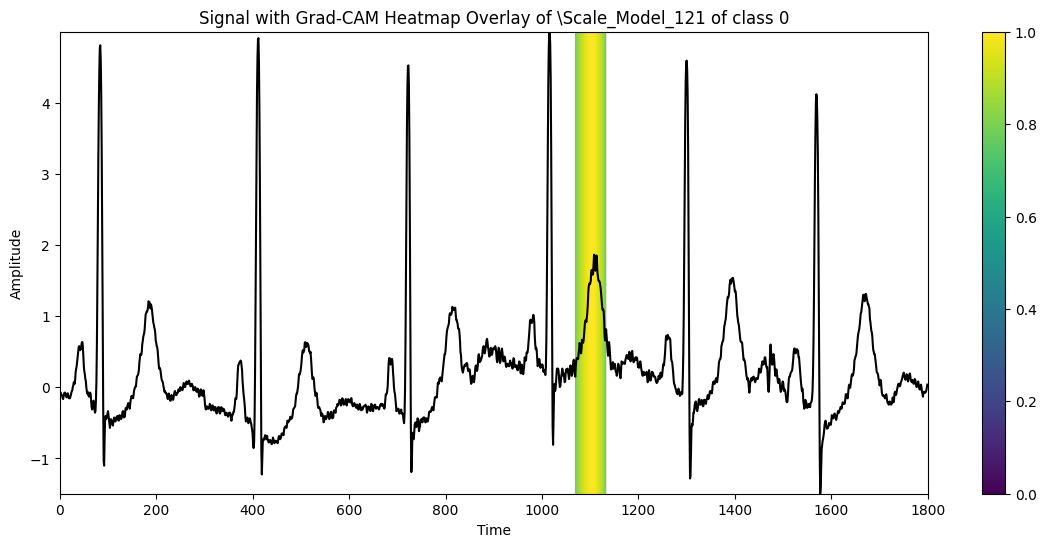

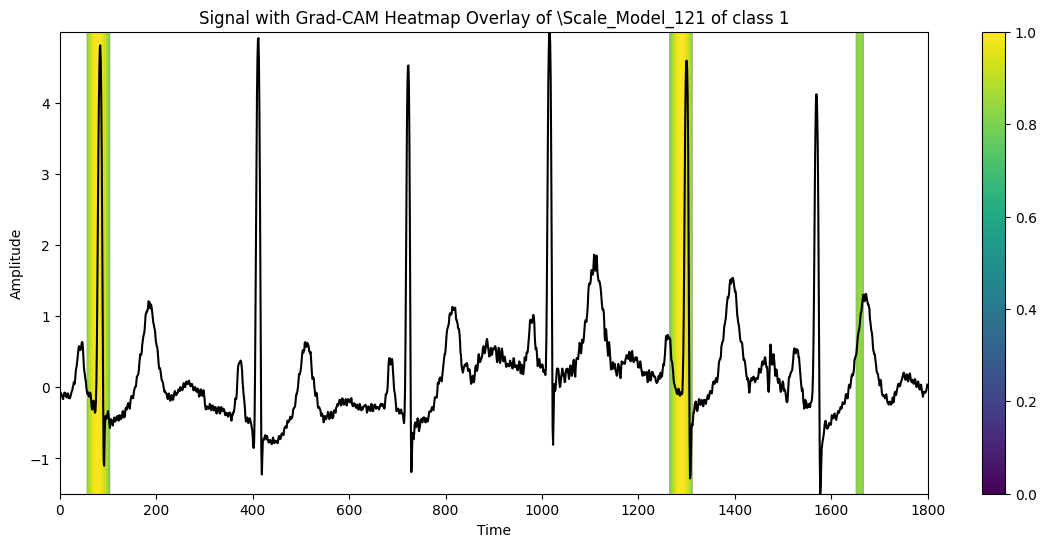

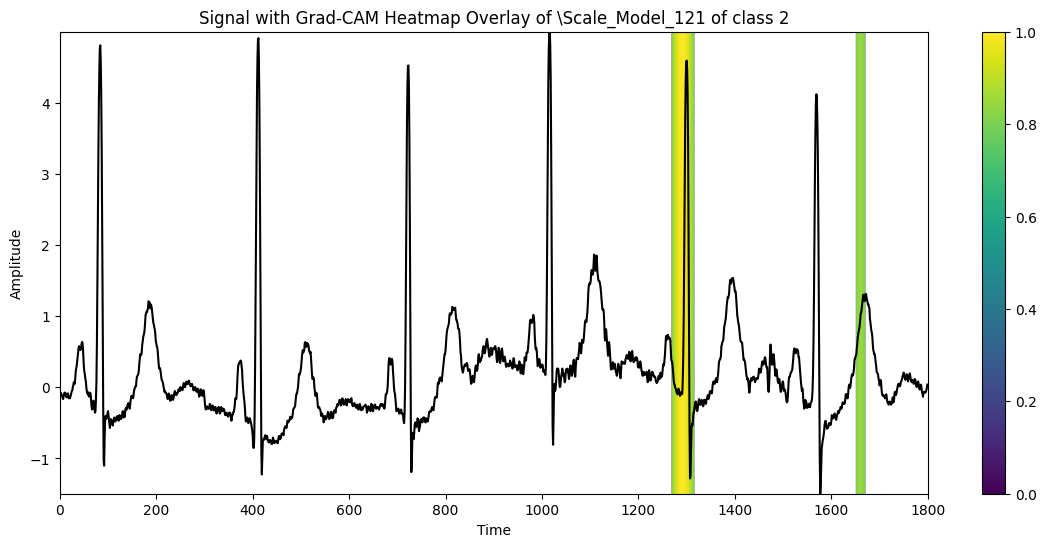

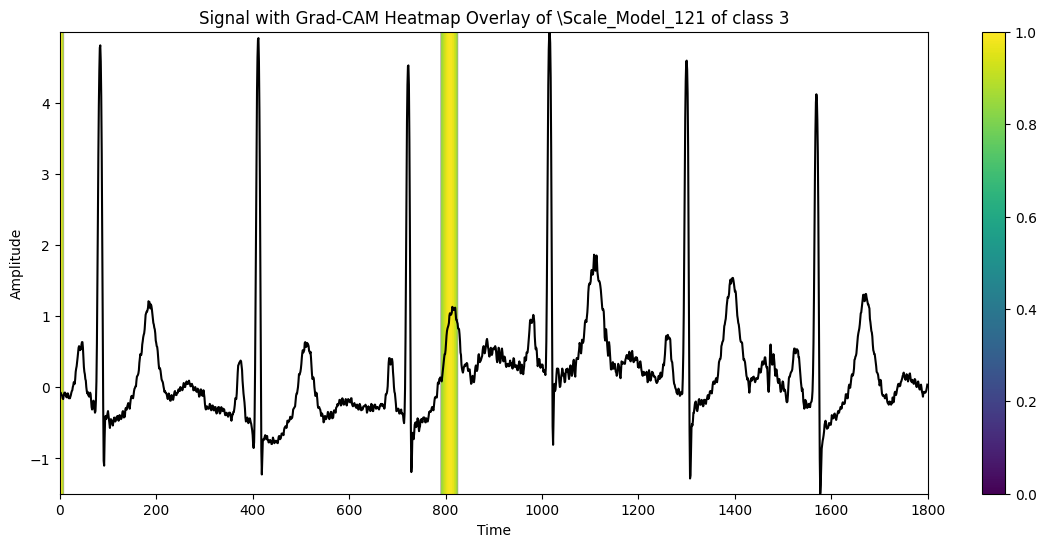

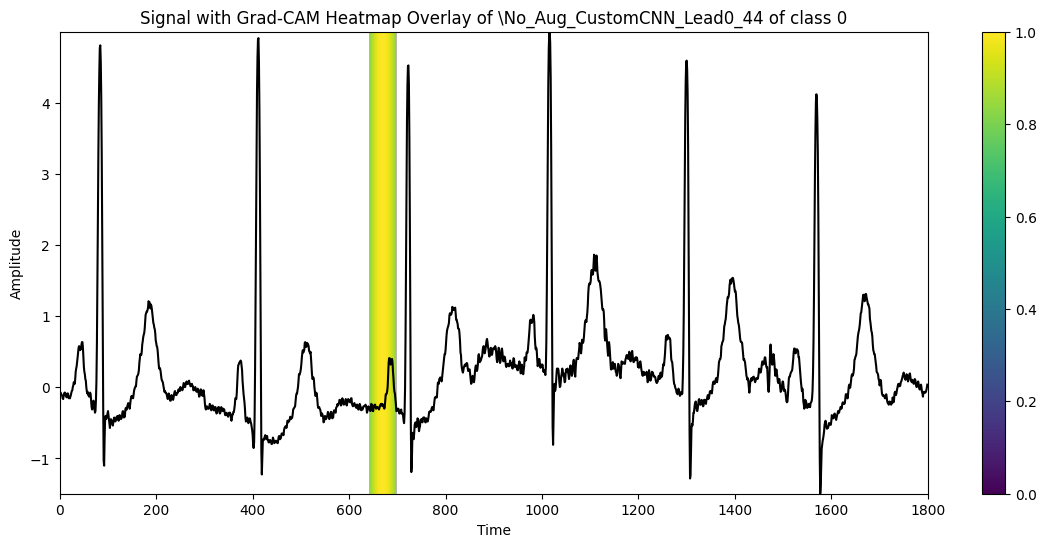

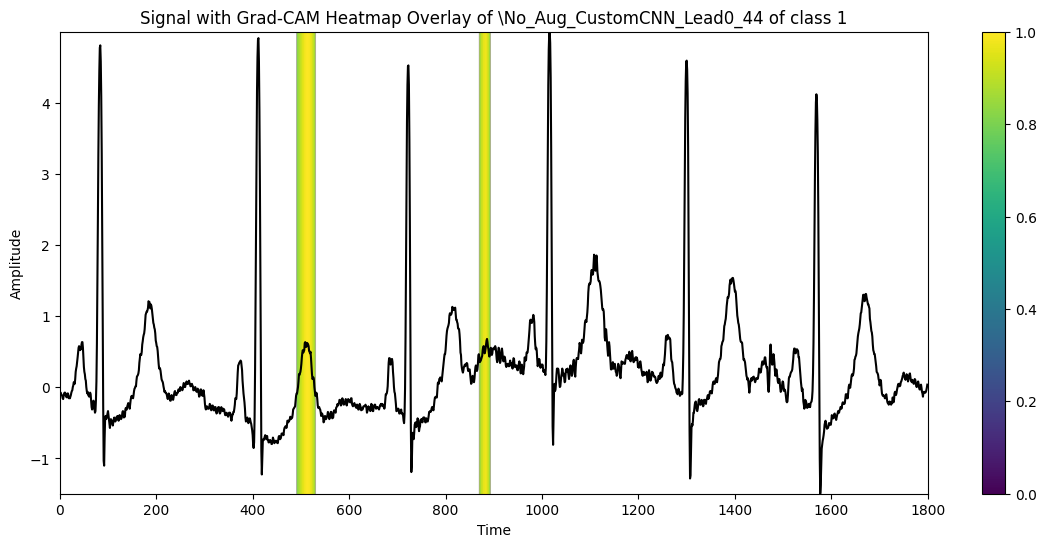

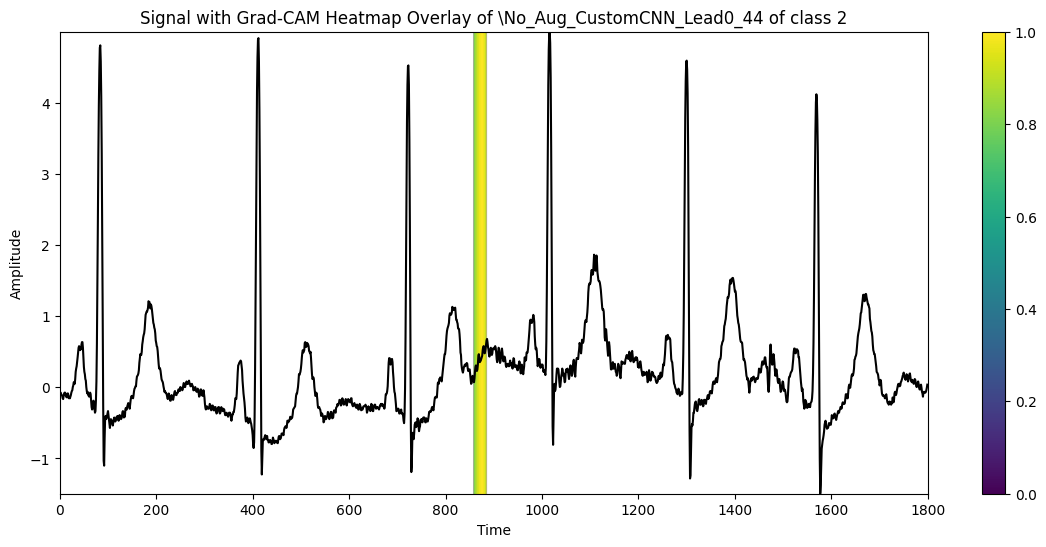

C:\Users\nbalasubramanian\AppData\Local\Temp\ipykernel_20228\941982264.py:21: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
C:\Users\nbalasubramanian\AppData\Local\Temp\ipykernel_20228\837261768.py:9: RuntimeWarning: invalid value encountered in divide
  normalized_heatmap = thresholded_heatmap / np.max(thresholded_heatmap)


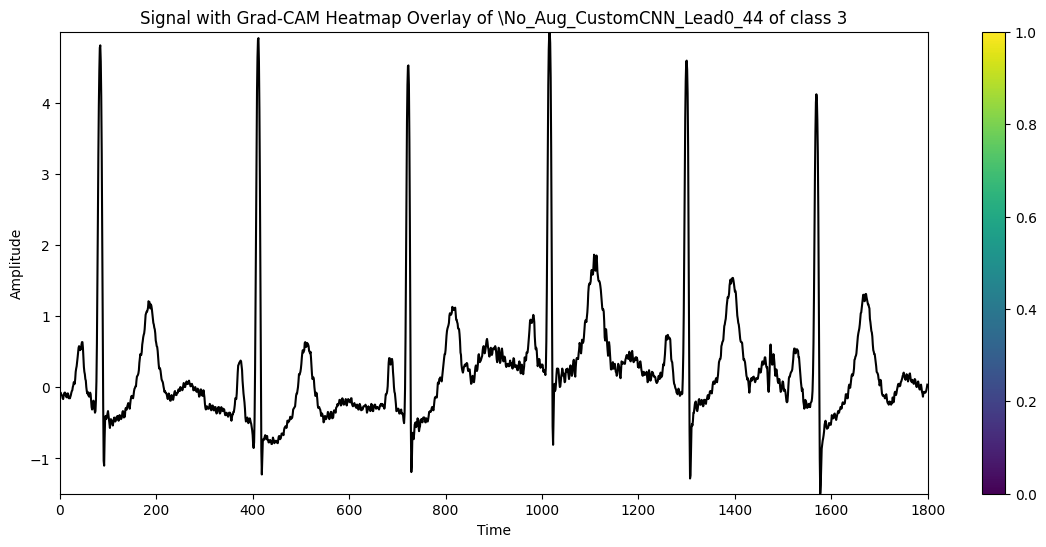

In [6]:
c=0
for model in models:
    for class_index in range(4):
        grad_model = tf.keras.models.Model(inputs=[model.inputs], outputs=[model.get_layer('conv13').output, model.output])
        plot_graph(grad_model,ckpt[c],class_index)
    c=c+1
